## Transformer Implementation

Implementation of the Transformer model (Vaswani et al, 2017). Based on Harvard's "The Annotated Transformer". 

In [3]:
!pip install torch numpy matplotlib spacy torchtext seaborn

     |████████████████████████████████| 59.9MB 17.3MB/s eta 0:00:01
     |████████████████████████████████| 15.0MB 63.5MB/s eta 0:00:01
     |████████████████████████████████| 14.4MB 30.0MB/s eta 0:00:01
     |████████████████████████████████| 34.4MB 42.6MB/s eta 0:00:01
     |████████████████████████████████| 61kB 31.7MB/s eta 0:00:01
     |████████████████████████████████| 215kB 72.8MB/s eta 0:00:01
     |████████████████████████████████| 122kB 81.2MB/s eta 0:00:01
     |████████████████████████████████| 71kB 29.9MB/s eta 0:00:01
     |████████████████████████████████| 61kB 37.6MB/s eta 0:00:01
     |████████████████████████████████| 2.9MB 65.1MB/s eta 0:00:01
     |████████████████████████████████| 3.0MB 80.2MB/s eta 0:00:01
     |████████████████████████████████| 61kB 31.4MB/s eta 0:00:01
     |████████████████████████████████| 276kB 63.1MB/s eta 0:00:01
     |████████████████████████████████| 153kB 75.1MB/s eta 0:00:01
     |████████████████████████████████| 51kB 26.3MB/s eta 0:00

     |████████████████████████████████| 512kB 65.9MB/s eta 0:00:01


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context='talk')
%matplotlib inline

/Users/nphung/Documents/Fall-2019-Independent-Study-Question-Answering/venv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/nphung/Documents/Fall-2019-Independent-Study-Question-Answering/venv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/nphung/Documents/Fall-2019-Independent-Study-Question-Answering/venv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/Users/nphung/Documents/Fall-2019-Independent-Study-Question-Answering/venv/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected

In [5]:
class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator
        
    def forward(self, src, tgt, src_mask, tgt_mask):
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)
    
    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)
    
    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [6]:
class Generator(nn.Module):
    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)
        
    def forward(self, x):
        return F.log_softmax(self.proj(x), dim=-1)

## Encoder and Decoder Stacks

**Encoder**

In [7]:
def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [9]:
class Encoder(nn.Module):
    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
    
    def forward(self, x, mask):
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)
    
class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps
        
    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2
    
class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, sublayer):
        return x + self.dropout(self.norm(x))

In [10]:
class EncoderLayer(nn.Module):
    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size
        
    def forward(self, x, mask):
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

**Decoder**

In [13]:
class Decoder(nn.Module):
    def __init__(self, layer, N):
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)
    
class DecoderLayer(nn.Module):
    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SubLayerConnection(size, dropouut), 3)
        
    def forward(self, x, memory, src_mask, tgt_mask):
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m,m ,src_mask))
        return self.sublayer[2](x, self.feed_forward)

In [14]:
def subsequent_mask(size):
    attn_shape = (1, size, size)
    subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    return torch.from_numpy(subsequent_mask) == 0

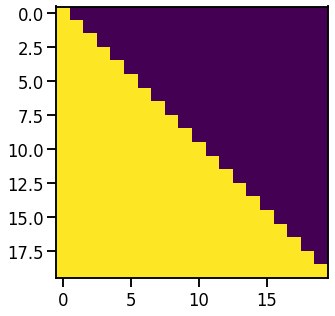

In [23]:
plt.figure(figsize=(5, 5))
plt.imshow(subsequent_mask(20)[0])

**Attention**

In [24]:
def attention(query, key, value, mask=None, dropout=None):
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    
    if mask:
        scores = torch.masked_fill(scores, mask==0, -1e9)
    
    p_attn = F.softmax(scores, dim=-1)
    if dropout:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn

In [25]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)
        
    def forward(self, query, key, value, mask=None):
        if mask:
            mask = torch.unsqueeze(mask, 1)
        n_batches = query.size(0)
        
        query, key, value = [l(x).view(n_batches, -1, self.h, self.d_k).transpose(1, 2) for l, x in zip(self.linears, (query, key, value))]
        
        x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)
        
        x = x.transpose(1, 2).contiguous().view(n_batches, -1, self.h * self.d_k)
        return self.linears[-1](x)

## References

1. Rush, A. (2018). The Annotated Transformer. http://nlp.seas.harvard.edu/2018/04/03/attention.html.
2. Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A, Kaiser, L., and Polosukhin, I. (2017). Attention is all you need. Advances in Neural Information Processing Systems.